In [1]:
import pandas as pd
import nltk
import numpy as np
import pymorphy2 as pymorphy2
import seaborn as sns
import inspect
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mikha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("posts.xlsx")
df.head()

,Unnamed: 0,id,date,text,publisher,reaction,comment
0,0,95367da2-8313-49c4-81f5-cbb1f8af69be,2023-01-14 17:17:08.793,"Что происходит на Мосбирже, останется на Мосби...",Pulse_Official,161,111.0
1,1,c179933b-b992-41a8-953c-e8cddce0a277,2023-01-13 16:30:00.000,В прямом эфире Василий Олейник и Ирина Ахмадул...,Tinkoff_Investments,140,29.0
2,2,9ee444e3-0ff1-4622-82b9-6ff7b1d00ec7,2023-01-12 06:50:00.000,Доброе утро! \nПродолжаем говорить на тематику...,Invest_Dim,315,149.0
3,3,4963f23d-f3ef-4c53-903e-74f62b851aab,2023-01-13 16:25:00.000,"Российский рынок \n\nНапоминаем, что по акциям...",Tinkoff_Investments,67,15.0
4,4,bedb0a0f-7657-4d27-a1fd-0b8005813eb5,2023-01-12 13:41:00.000,📊 Инфляционные ожидания: что такое и зачем их ...,FinDay,105,12.0


In [3]:
df.describe()

,Unnamed: 0,reaction,comment
count,3450.000000,3450.000000,3418.000000
mean,1724.500000,161.273043,177.120538
std,996.073541,147.782744,937.298884
min,0.000000,2.000000,1.000000
25%,862.250000,65.000000,16.000000
50%,1724.500000,129.000000,40.000000
75%,2586.750000,214.000000,91.000000
max,3449.000000,1672.000000,12891.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3450 entries, 0 to 3449
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  3450 non-null   int64         
 1   id          3450 non-null   object        
 2   date        3450 non-null   datetime64[ns]
 3   text        3450 non-null   object        
 4   publisher   3450 non-null   object        
 5   reaction    3450 non-null   int64         
 6   comment     3418 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 188.8+ KB


In [5]:
df.isnull().sum()

Unnamed: 0     0
id             0
date           0
text           0
publisher      0
reaction       0
comment       32
dtype: int64

In [6]:
df['comment'] = df['comment'].fillna(0)

In [7]:
import re


def standardize_text(text):
    text = text.lower()
    text = re.sub('@[^\s]+', '', text)
    text = re.sub('_', ' ', text)
    text = re.sub('http[^\s]+', '', text)
    text = re.sub('\$\d+\.\d{2}', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub("[^\w\s]", "", text)  # возможно плохая
    text = re.sub('\n', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub(' +', ' ', text)
    return text



In [8]:
df['text'][8]


'🤓 Японские свечи, топливные брикеты и история о дружбе инвесторов\n\nОбсуждаем самые популярные и интересные посты этой недели в Пульсе.\n\n🧬В топе по просмотрам сплошь новостные дайджесты. Самые популярные от\xa0 @Dengy_ne_problema (около 15 тыс. просмотров), @Fomag.ru (13,4 тыс) и @Yverenno (12,1 тыс).\n\n🧬Но нам бы хотелось отметить образовательный пост @GilmanovMedia про японские свечи. Наглядно (с картинкой) и просто автор объясняет, как работает инструмент технического анализа и, что важно, не выдает его за панацею. Результат — больше 400 комментов и 100 лайков, 11,5 тыс. просмотров.\xa0\n\n🧬Также в топе по лайкам пост про зависание нашего приложения от @GoodMoneyWork (397 лайков). Все оперативно починили, спасибо, что помогаете нам находить и исправлять ошибки. А также обзор российского рынка на постпраздничной неделе от @Karsotel (348 лайков).\xa0\n\n🧬Бодро ворвалась в Пульс редакция информагентства для трейдеров и инвесторов Биржевик — @BirzhevikOfficial. Ребята пишут годный 

In [9]:
df['text'] = df['text'].apply(standardize_text)

In [10]:
df['text'][8]

' японские свечи топливные брикеты и история о дружбе инвесторов обсуждаем самые популярные и интересные посты этой недели в пульсе в топе по просмотрам сплошь новостные дайджесты самые популярные от около тыс просмотров тыс и тыс но нам бы хотелось отметить образовательный пост про японские свечи наглядно с картинкой и просто автор объясняет как работает инструмент технического анализа и что важно не выдает его за панацею результат больше комментов и лайков тыс просмотров также в топе по лайкам пост про зависание нашего приложения от лайков все оперативно починили спасибо что помогаете нам находить и исправлять ошибки а также обзор российского рынка на постпраздничной неделе от лайков бодро ворвалась в пульс редакция информагентства для трейдеров и инвесторов биржевик ребята пишут годный контент быстро набирают подписчиков и лайки у приветственного поста так держать также в топе по количеству лайков с новостью о том что компания начала продавать топливные брикеты на ozon здорово когда

# Tokenization with NLTK

In [11]:
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df['token'] = df['text'].apply(word_tokenize)
df.head()

,Unnamed: 0,id,date,text,publisher,reaction,comment,token
0,0,95367da2-8313-49c4-81f5-cbb1f8af69be,2023-01-14 17:17:08.793,что происходит на мосбирже останется на мосбир...,Pulse_Official,161,111.0,"[что, происходит, на, мосбирже, останется, на,..."
1,1,c179933b-b992-41a8-953c-e8cddce0a277,2023-01-13 16:30:00.000,в прямом эфире василий олейник и ирина ахмадул...,Tinkoff_Investments,140,29.0,"[в, прямом, эфире, василий, олейник, и, ирина,..."
2,2,9ee444e3-0ff1-4622-82b9-6ff7b1d00ec7,2023-01-12 06:50:00.000,доброе утро продолжаем говорить на тематику ма...,Invest_Dim,315,149.0,"[доброе, утро, продолжаем, говорить, на, темат..."
3,3,4963f23d-f3ef-4c53-903e-74f62b851aab,2023-01-13 16:25:00.000,российский рынок напоминаем что по акциям сбер...,Tinkoff_Investments,67,15.0,"[российский, рынок, напоминаем, что, по, акция..."
4,4,bedb0a0f-7657-4d27-a1fd-0b8005813eb5,2023-01-12 13:41:00.000,инфляционные ожидания что такое и зачем их оц...,FinDay,105,12.0,"[инфляционные, ожидания, что, такое, и, зачем,..."


In [13]:
all_words = [word for tokens in df["token"] for word in tokens]
text_lengths = [len(tokens) for tokens in df["token"]]
VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(text_lengths))

898709 words total, with a vocabulary size of 59224
Max sentence length is 1768


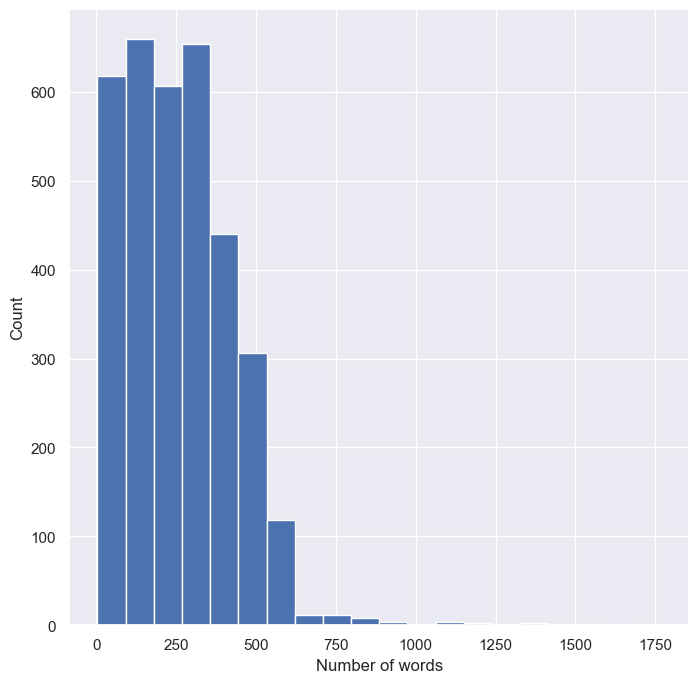

In [14]:
fig = plt.figure(figsize=(8, 8))
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.hist(text_lengths, bins=20)
plt.show()

### Remove stop words

In [15]:
def remove_stopwords(text, vocab_set):
    words = [w for w in text if w not in vocab_set]
    return words

In [16]:

df['token'] = df['token'].apply(lambda x: remove_stopwords(x, stopwords.words('russian')))

In [17]:
df['token']

0       [происходит, мосбирже, останется, мосбирже, эг...
1       [прямом, эфире, василий, олейник, ирина, ахмад...
2       [доброе, утро, продолжаем, говорить, тематику,...
3       [российский, рынок, напоминаем, акциям, сбера,...
4       [инфляционные, ожидания, такое, оценивать, эко...
                              ...                        
3445    [продолжаем, публиковать, расписание, финансов...
3446    [чипы, кризис, нужны, акции, полупроводниковых...
3447    [году, курс, долларрубль, успел, взлететь, зат...
3448    [делать, свободными, рублями, депозиты, людей,...
3449    [гмк, норникель, gmkn, обзор, компании, новых,...
Name: token, Length: 3450, dtype: object

### Let's look how many words left after removing stop words

In [18]:
all_words_tr = [word for tokens in df["token"] for word in tokens]
text_lengths_tr = [len(tokens) for tokens in df["token"]]
vocab_tr = sorted(list(set(all_words_tr)))

print("%s words total, with a vocabulary size of %s" % (len(all_words_tr), len(vocab_tr)))
print("Max sentence length is %s" % max(text_lengths_tr))

636805 words total, with a vocabulary size of 59073
Max sentence length is 1298


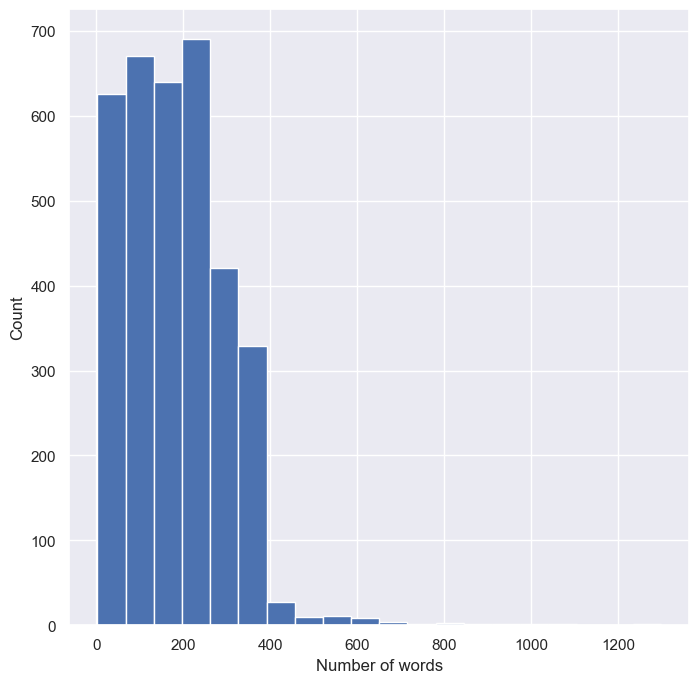

In [19]:
fig = plt.figure(figsize=(8, 8))
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.hist(text_lengths_tr, bins=20)
plt.show()

In [20]:
print("Word's dropped in total:", len(all_words) - len(all_words_tr))
print("Word's dropped from vocabulary:", len(VOCAB) - len(vocab_tr))

Word's dropped in total: 261904
Word's dropped from vocabulary: 151


### Lemmatization

In [21]:
import pymorphy2
from pymorphy2 import MorphAnalyzer

In [22]:
morph = MorphAnalyzer()


def lemmatize(text):
    text = [morph.normal_forms(x)[0] for x in text]
    return text

In [23]:
series_lem = df['token'].apply(lemmatize)
series_lem.head(10)


0    [происходить, мосбиржа, остаться, мосбиржа, эг...
1    [прямой, эфир, василий, олейник, ирина, ахмаду...
2    [добрый, утро, продолжать, говорить, тематика,...
3    [российский, рынок, напоминать, акция, сбер, о...
4    [инфляционный, ожидание, такой, оценивать, эко...
5    [ценный, бумага, другой, финансовый, инструмен...
6    [рассказывать, показывать, почему, центробанк,...
7    [продолжение, легендарный, курс, весь, обещать...
8    [японский, свеча, топливный, брикет, история, ...
9    [какой, реальный, исторический, событие, фильм...
Name: token, dtype: object

#### Check words frequency

In [24]:
from nltk.probability import FreqDist

In [25]:
corpus = [word for i in series_lem for word in i]
corpus[10:20]

['бодрый',
 'бывать',
 'индекс',
 'мосбиржа',
 'отжиматься',
 'бросок',
 'пока',
 'сам',
 'знать',
 'голубой']

<AxesSubplot:>

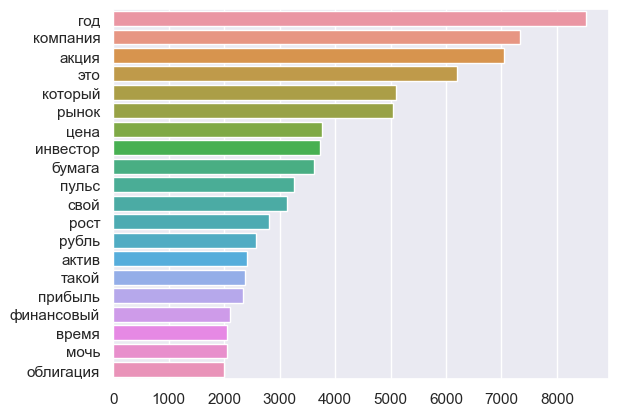

In [26]:
most_common = FreqDist(corpus).most_common(20)
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)

sns.barplot(x=frequency, y=words)

In [27]:
FreqDist(corpus).most_common(50)

[('год', 8519),
 ('компания', 7333),
 ('акция', 7044),
 ('это', 6189),
 ('который', 5092),
 ('рынок', 5052),
 ('цена', 3770),
 ('инвестор', 3733),
 ('бумага', 3624),
 ('пульс', 3262),
 ('свой', 3135),
 ('рост', 2801),
 ('рубль', 2569),
 ('актив', 2402),
 ('такой', 2383),
 ('прибыль', 2338),
 ('финансовый', 2103),
 ('время', 2055),
 ('мочь', 2053),
 ('облигация', 2000),
 ('млрд', 1919),
 ('риск', 1868),
 ('портфель', 1831),
 ('уровень', 1826),
 ('инвестиция', 1783),
 ('также', 1782),
 ('ценный', 1686),
 ('биржа', 1660),
 ('другой', 1620),
 ('день', 1616),
 ('один', 1612),
 ('сделка', 1565),
 ('ставка', 1547),
 ('дивиденд', 1546),
 ('новый', 1521),
 ('быть', 1511),
 ('первый', 1501),
 ('счёт', 1495),
 ('результат', 1492),
 ('российский', 1485),
 ('самый', 1452),
 ('индекс', 1439),
 ('продажа', 1432),
 ('деньга', 1410),
 ('доходность', 1394),
 ('выручка', 1357),
 ('наш', 1333),
 ('ваш', 1328),
 ('стоимость', 1287),
 ('хороший', 1282)]

We can see, that words like "**который**" and "**это**" are popular, but will not have impact on model. We should drop them

In [28]:
stop_words = ["это", "который", "свой", 'такой', 'также']
series_lem = series_lem.apply(lambda x: remove_stopwords(x, stop_words))

In [29]:
df['token_lem'] = series_lem.apply(lambda x: ' '.join(x))
df.to_csv('preprocessed_posts.csv', index=False)

In [30]:
corpus = [word for i in series_lem for word in i]
FreqDist(corpus).most_common(100)

[('год', 8519),
 ('компания', 7333),
 ('акция', 7044),
 ('рынок', 5052),
 ('цена', 3770),
 ('инвестор', 3733),
 ('бумага', 3624),
 ('пульс', 3262),
 ('рост', 2801),
 ('рубль', 2569),
 ('актив', 2402),
 ('прибыль', 2338),
 ('финансовый', 2103),
 ('время', 2055),
 ('мочь', 2053),
 ('облигация', 2000),
 ('млрд', 1919),
 ('риск', 1868),
 ('портфель', 1831),
 ('уровень', 1826),
 ('инвестиция', 1783),
 ('ценный', 1686),
 ('биржа', 1660),
 ('другой', 1620),
 ('день', 1616),
 ('один', 1612),
 ('сделка', 1565),
 ('ставка', 1547),
 ('дивиденд', 1546),
 ('новый', 1521),
 ('быть', 1511),
 ('первый', 1501),
 ('счёт', 1495),
 ('результат', 1492),
 ('российский', 1485),
 ('самый', 1452),
 ('индекс', 1439),
 ('продажа', 1432),
 ('деньга', 1410),
 ('доходность', 1394),
 ('выручка', 1357),
 ('наш', 1333),
 ('ваш', 1328),
 ('стоимость', 1287),
 ('хороший', 1282),
 ('стать', 1272),
 ('получить', 1266),
 ('являться', 1263),
 ('сша', 1256),
 ('неделя', 1255),
 ('инструмент', 1249),
 ('месяц', 1249),
 ('дохо

In [31]:
from nltk import ngrams

n = 2
ngrams_2_series = series_lem.apply(lambda x: list(map(' '.join, ngrams(x, n=n))))
FreqDist([word for i in ngrams_2_series for word in i]).most_common(100)

[('ценный бумага', 1636),
 ('учить пульс', 830),
 ('проявить пульс', 793),
 ('фондовый рынок', 646),
 ('пульс пульс', 634),
 ('год год', 598),
 ('пульс оценить', 584),
 ('чистый прибыль', 540),
 ('финансовый инструмент', 527),
 ('тинькофф инвестиция', 506),
 ('млрд рубль', 442),
 ('читать обзор', 432),
 ('бумага другой', 425),
 ('новость news', 424),
 ('другой финансовый', 414),
 ('млрд руб', 368),
 ('акция компания', 344),
 ('пульс новичок', 321),
 ('пульс проявить', 320),
 ('народный портфель', 320),
 ('спб биржа', 319),
 ('процентный ставка', 317),
 ('цена акция', 285),
 ('купить продать', 271),
 ('российский рынок', 264),
 ('иностранный ценный', 261),
 ('второй квартал', 255),
 ('денежный средство', 253),
 ('источник новость', 243),
 ('финансовый результат', 229),
 ('инвестиционный идея', 222),
 ('бумага мочь', 219),
 ('индекс мосбиржа', 218),
 ('квартал год', 217),
 ('рост цена', 217),
 ('являться инвестиционный', 212),
 ('продать ценный', 212),
 ('обратить внимание', 211),
 ('упо